In [1]:
import xarray as xr
import numpy as np
import scipy as sc
import sklearn as skl
import skimage as ski
import pysteps
from pysteps.verification.spatialscores import fss, intensity_scale
from pysteps.verification.salscores import sal
from pysteps.verification.detcontscores import det_cont_fct
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import copy

Pysteps configuration file found at: /work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/pysteps/pystepsrc



In [2]:
event_ID=0
def region_sel(event_ID):
    ##% REGION SELECTION
    if event_ID==0:
        ###USA
        year=2020; month=np.arange(3,10); 
        latslice=slice(20,50); lonslice=slice(250,300)
        lon_conv=False
        flag='USA'
    elif event_ID==1:
        ###ARGENTINA
        year=2020; month=(9,10,11,12,1,2)
        latslice=slice(-40,-25); lonslice=slice(290,310)
        lon_conv=False
        flag='ARG'
    elif event_ID==2:
        ###AUSTRALIA
        year=2020; month=(9,10,11,12,1,2)
        latslice=slice(-35,-20); lonslice=slice(140,155)
        lon_conv=False
        flag='AUS'
    elif event_ID==3:
        ###CHINA
        year=2020; month=np.arange(4,10)
        latslice=slice(20,35); lonslice=slice(100,120)
        lon_conv=False
        flag='CHN'
    elif event_ID==4:
        ###EUROPE
        year=2020; month=np.arange(4,10)
        latslice=slice(35,55); lonslice=slice(-10,30)
        lon_conv=True
        flag='EUR'
    return year, month, latslice, lonslice, lon_conv, flag

year, month, latslice, lonslice, lon_conv, flag = region_sel(event_ID)

In [3]:
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020_'+flag+'/'
models=['graphcast_','graphcast-oper_','pangu_','pangu-oper_','ifs_','sfno_','sfno-oper_']#'fcnv2_dawn','ifs']
labels=['graphcast','graphcast-oper','pangu','pangu-oper','ifs','sfno','sfno-oper']
references=[flag+'_era5_convseason_2020.nc',flag+'_init_convseason_2020.nc']
rlabels=['era5','ifs-init']
#figpath='/users/mfeldman/figs/season/'+flag+'_'
figpath='/users/mfeldman/figs/pub/'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black
c7='#f3322f' #red
colors=[c2,c1,c3,c7,c6,c5,c4]#c5


In [4]:
###CASE VIS
event_ID==0
year, month, latslice, lonslice, lon_conv, flag = region_sel(event_ID)
savepath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020_'+flag+'/'
year=2020; month=4; day=np.arange(12,14,1)
latslice=slice(20,40);lonslice =slice(260,290)

###LOAD ERA-5
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
xr_era5=xr.open_zarr(era5).sortby('latitude')#.fillna(0)
xr_era5=xr_era5.sel(time=xr_era5.time.dt.year.isin([year]))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.month.isin([month]))#np.arange(3,10)))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.day.isin([day]),latitude=latslice,longitude=lonslice)

conv_era5=xr.open_dataset(savepath+flag+'_init_convseason_2020.nc').sortby('latitude').fillna(0)
conv_era5=conv_era5.sel(time=conv_era5.time.dt.year.isin([year]))
conv_era5=conv_era5.sel(time=conv_era5.time.dt.month.isin([month]))#np.arange(3,10)))
conv_era5=conv_era5.sel(time=conv_era5.time.dt.day.isin([day]),latitude=latslice,longitude=lonslice)


In [5]:

###LOAD CLIMATOLOGY
era5_clim='gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_1440x721.zarr'
xr_clim=xr.open_zarr(era5_clim).sortby('latitude')#.fillna(0)
xr_clim=xr_clim.sel(latitude=latslice,longitude=lonslice)
xr_clim=xr_clim.sel(dayofyear=np.arange(72,74,1))
xr_clim1=xr_clim.stack(time=('dayofyear','hour'), create_index=False).transpose('time', 'latitude', 'longitude', 'level')
# xr_clim1.time=xr_era5.time.values
xr_clim1 = xr_clim1.assign_coords(time=xr_era5.time.values)
print("Original dimensions:", xr_clim1.dims)
xr_clim2 = xr_clim1.transpose('time',...)
print("New dimensions:", xr_clim2.dims)
print("Original dimensions:", xr_era5.dims)
xr_era5_1 = xr_era5.transpose('time', 'latitude', 'longitude', 'level')
print("New dimensions:", xr_era5_1.dims)
xr_era5['d_mslp']=xr_era5_1.mean_sea_level_pressure-xr_clim2.mean_sea_level_pressure.values
xr_era5['d_z']=(xr_era5_1.geopotential-xr_clim2.geopotential.values) / 9.81
xr_era5['d_t2m']=xr_era5_1['2m_temperature']-xr_clim2['2m_temperature']



Original dimensions: FrozenMappingWarningOnValuesAccess({'time': 8, 'latitude': 81, 'longitude': 121, 'level': 13})
New dimensions: FrozenMappingWarningOnValuesAccess({'time': 8, 'latitude': 81, 'longitude': 121, 'level': 13})
Original dimensions: FrozenMappingWarningOnValuesAccess({'time': 8, 'latitude': 81, 'longitude': 121, 'level': 13})
New dimensions: FrozenMappingWarningOnValuesAccess({'time': 8, 'latitude': 81, 'longitude': 121, 'level': 13})


In [13]:
print(xr_clim1.dims)
print(xr_era5.dims)

FrozenMappingWarningOnValuesAccess({'time': 8, 'latitude': 221, 'longitude': 241, 'level': 13})
FrozenMappingWarningOnValuesAccess({'time': 8, 'latitude': 81, 'longitude': 121, 'level': 13})


making plot


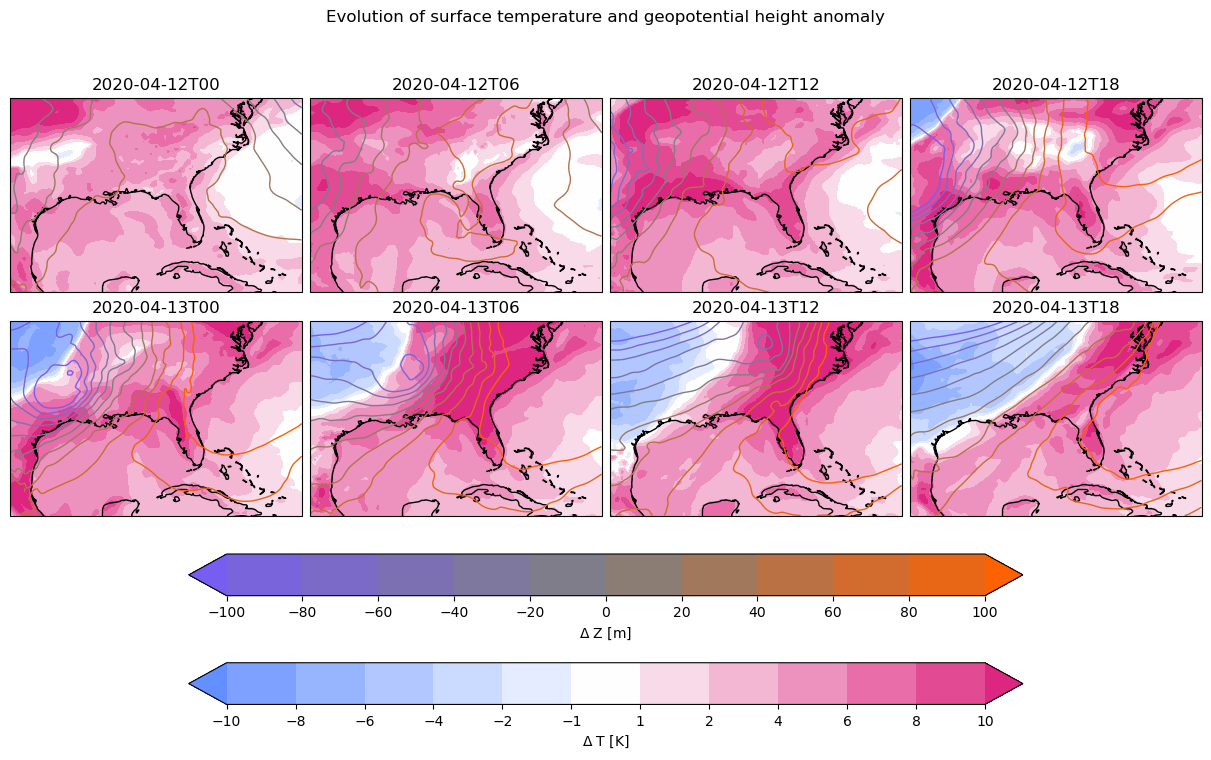

In [11]:
from matplotlib import colors
import cartopy.crs as ccrs
###T & Z PLOT
cm= colors.LinearSegmentedColormap.from_list('mycmap', ['#FFFFFF', '#dc267f'])
cm.set_under(color="grey")
cm.set_bad(color="grey")
cmd = colors.LinearSegmentedColormap.from_list('mycmap', [ '#FFFFFF','#648fff'])  
cmd2 = colors.LinearSegmentedColormap.from_list('mycmap', ['#648fff', '#FFFFFF', '#dc267f'])  
cmd3 = colors.LinearSegmentedColormap.from_list('mycmap', ['#785ef0', '#808080', '#fe6100'])   
print('making plot')
n=0
projection = ccrs.PlateCarree()
#era_ref=era_ref.assign(mean_sea_level_pressure=lambda era_ref: xr_era5.mean_sea_level_pressure)
fig2,axes2 = plt.subplots(2,4,figsize=(12, 8), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
axs_flat = axes2.flatten()
for i, ax in enumerate(axs_flat):
    data=xr_era5.isel(time=n)

    d2=data.d_z.sel(level=500).plot.contourf(ax=ax, transform=projection, x='longitude', y='latitude',
         #colors=['black','black','black','black','black','black','grey','grey','grey','grey','grey','grey'],
         cmap=cmd3,
         vmin=-100,vmax=100,levels=np.arange(-100,110,20), add_colorbar=False)
    
    contour_plot=data.d_t2m.plot.contourf(ax=ax, transform=projection,x='longitude', y='latitude',
        cmap=cmd2,vmin=-10,vmax=10,levels=[-10,-8,-6,-4,-2,-1,1,2,4,6,8,10],extend='both', add_colorbar=False)

    data.d_z.sel(level=500).plot.contour(ax=ax, transform=projection, x='longitude', y='latitude',
         #colors=['black','black','black','black','black','black','grey','grey','grey','grey','grey','grey'],
         cmap=cmd3,
         vmin=-100,vmax=100,levels=np.arange(-100,110,20),linewidths=1, add_colorbar=False)


    ax.coastlines()
    ax.set_title('') # to supress xarray auto-title
    ax.set_title(np.datetime_as_string(data.time.values,unit='h'));
    n+=1
cbar = fig2.colorbar(contour_plot, ax=axes2, orientation='horizontal', shrink=0.7,ticks=[-10,-8,-6,-4,-2,-1,1,2,4,6,8,10])
cbar.set_label('$\Delta$ T [K]')
cbar = fig2.colorbar(d2, ax=axes2, orientation='horizontal', shrink=0.7, ticks=np.arange(-100,110,20))
cbar.set_label('$\Delta$ Z [m]')
fig2.suptitle('Evolution of surface temperature and geopotential height anomaly')
#plt.tight_layout()
fig2.savefig(figpath+'plot_era5_T_z.png',  dpi=300, bbox_inches='tight')


making plot


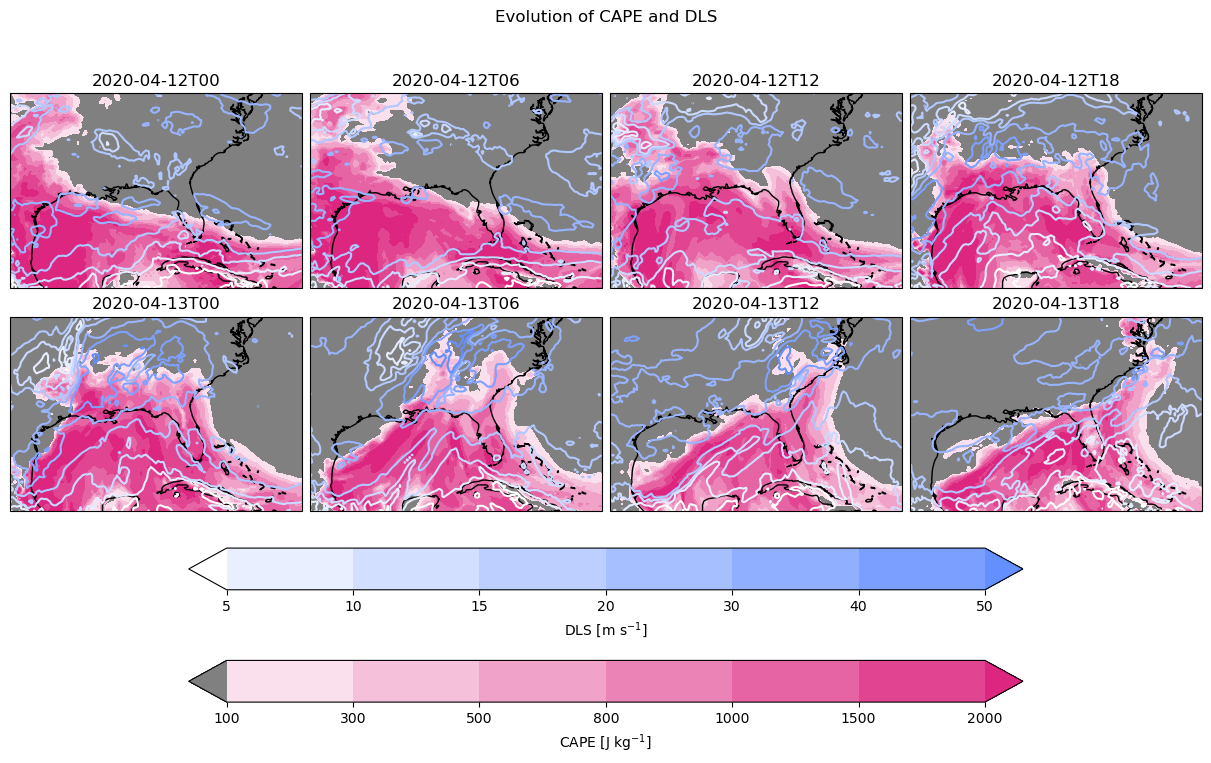

In [63]:

###CAPE PLOT
cm= colors.LinearSegmentedColormap.from_list('mycmap', ['#FFFFFF', '#dc267f'])
cm.set_under(color="grey")
cm.set_bad(color="grey")
cmd = colors.LinearSegmentedColormap.from_list('mycmap', [ '#FFFFFF','#648fff'])  
cmd2 = colors.LinearSegmentedColormap.from_list('mycmap', ['#648fff', '#FFFFFF', '#dc267f'])  
cmd3 = colors.LinearSegmentedColormap.from_list('mycmap', ['#785ef0', '#808080', '#fe6100'])  
print('making plot')
n=0
projection = ccrs.PlateCarree()
#era_ref=era_ref.assign(mean_sea_level_pressure=lambda era_ref: xr_era5.mean_sea_level_pressure)
fig2,axes2 = plt.subplots(2,4,figsize=(12, 8), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
axs_flat = axes2.flatten()
for i, ax in enumerate(axs_flat):
    data=conv_era5.isel(time=n)

    line_plot=data.bs_06.plot.contourf(ax=ax, transform=projection, x='longitude', y='latitude',
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both', add_colorbar=False)

    contour_plot=data.cape.plot.contourf(ax=ax, transform=projection,x='longitude', y='latitude',
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)

    data.bs_06.plot.contour(ax=ax, transform=projection, x='longitude', y='latitude',
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both')


    ax.coastlines()
    ax.set_title('') # to supress xarray auto-title
    ax.set_title(np.datetime_as_string(data.time.values,unit='h'));
    n+=1
cbar = fig2.colorbar(contour_plot, ax=axes2, orientation='horizontal', shrink=0.7,ticks=[100,300,500,800,1000,1500,2000])
cbar.set_label('CAPE [J kg$^{-1}$]')
cbar = fig2.colorbar(line_plot, ax=axes2, orientation='horizontal', shrink=0.7,ticks=[5,10,15,20,30,40,50])
cbar.set_label('DLS [m s$^{-1}$]')
fig2.suptitle('Evolution of CAPE and DLS')
#plt.tight_layout()
fig2.savefig(figpath+'plot_era5_cape_dls.png',  dpi=300, bbox_inches='tight')

In [32]:
conv_era5=xr.open_dataset(savepath+flag+'_init_convseason_2020.nc').sortby('latitude').fillna(0)
conv_era5=conv_era5.sel(time=conv_era5.time.dt.year.isin([year]))
conv_era5=conv_era5.sel(time=conv_era5.time.dt.month.isin([month]))#np.arange(3,10)))
conv_era5=conv_era5.sel(time=conv_era5.time.dt.day.isin([day]),latitude=latslice,longitude=lonslice)

making plot


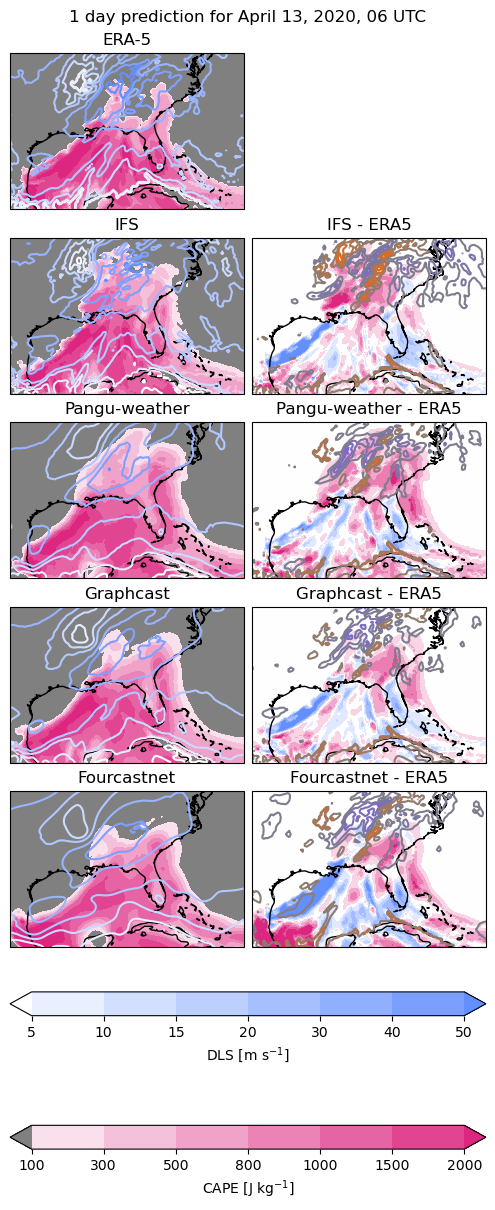

In [63]:
###READ FORECAST AT LEADTIME 1 DAY
date='2020041200'
ii=4
pangu=xr.open_dataset(savepath+flag+'_conv_pangu-oper_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
graphcast=xr.open_dataset(savepath+flag+'_conv_graphcast-oper_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
fourcastnet=xr.open_dataset(savepath+flag+'_conv_sfno-oper_'+date+'00.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
ifs=xr.open_dataset(savepath+flag+'_conv_ifs_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii+1).sel(latitude=latslice,longitude=lonslice)
era5=conv_era5.sel(time=pangu.time.values+pangu.prediction_timedelta.values)
###CAPE PLOT
cm= colors.LinearSegmentedColormap.from_list('mycmap', ['#FFFFFF', '#dc267f'])
cm.set_under(color="grey")
cm.set_bad(color="grey")
cmd = colors.LinearSegmentedColormap.from_list('mycmap', [ '#FFFFFF','#648fff'])  
cmd2 = colors.LinearSegmentedColormap.from_list('mycmap', ['#648fff', '#FFFFFF', '#dc267f'])  
cmd3 = colors.LinearSegmentedColormap.from_list('mycmap', ['#785ef0', '#808080', '#fe6100'])  
print('making plot')
n=0
projection = ccrs.PlateCarree()
#era_ref=era_ref.assign(mean_sea_level_pressure=lambda era_ref: xr_era5.mean_sea_level_pressure)
fig,axes = plt.subplots(5,2,figsize=(8,12), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')

line_plot=era5.bs_06.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[0,0],
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both', add_colorbar=False)
contour_plot=era5.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[0,0],
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
era5.bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[0,0],
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both')
axes[0,0].coastlines()
axes[0,0].set_title('') # to supress xarray auto-title
axes[0,0].set_title('ERA-5')

ifs.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[1,0],
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
ifs.bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[1,0],
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both')
axes[1,0].coastlines()
axes[1,0].set_title('') # to supress xarray auto-title
axes[1,0].set_title('IFS')


pangu.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[2,0],
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
pangu.bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[2,0],
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both')
axes[2,0].coastlines()
axes[2,0].set_title('') # to supress xarray auto-title
axes[2,0].set_title('Pangu-weather')


graphcast.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[3,0],
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
graphcast.bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[3,0],
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both')
axes[3,0].coastlines()
axes[3,0].set_title('') # to supress xarray auto-title
axes[3,0].set_title('Graphcast')


fourcastnet.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[4,0],
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
fourcastnet.bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[4,0],
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both')
axes[4,0].coastlines()
axes[4,0].set_title('') # to supress xarray auto-title
axes[4,0].set_title('Fourcastnet')


(ifs-era5).cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[1,1],
        cmap=cmd2,vmin=-1000,vmax=1000,levels=[-1000,-800,-500,-300,-100,100,300,500,800,1000],extend='both', add_colorbar=False)
(ifs-era5).bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[1,1],
         cmap=cmd3,vmin=-31,vmax=31,levels=[-30,-20,-15,-10,-5,5,10,15,20,30],extend='both')
axes[1,1].coastlines()
axes[1,1].set_title('') # to supress xarray auto-title
axes[1,1].set_title('IFS - ERA5')


(pangu-era5).cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[2,1],
        cmap=cmd2,vmin=-1000,vmax=1000,levels=[-1000,-800,-500,-300,-100,100,300,500,800,1000],extend='both', add_colorbar=False)
(pangu-era5).bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[2,1],
         cmap=cmd3,vmin=-31,vmax=31,levels=[-30,-20,-15,-10,-5,5,10,15,20,30],extend='both')
axes[2,1].coastlines()
axes[2,1].set_title('') # to supress xarray auto-title
axes[2,1].set_title('Pangu-weather - ERA5')


(graphcast-era5).cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[3,1],
        cmap=cmd2,vmin=-1000,vmax=1000,levels=[-1000,-800,-500,-300,-100,100,300,500,800,1000],extend='both', add_colorbar=False)
(graphcast-era5).bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[3,1],
         cmap=cmd3,vmin=-31,vmax=31,levels=[-30,-20,-15,-10,-5,5,10,15,20,30],extend='both')
axes[3,1].coastlines()
axes[3,1].set_title('') # to supress xarray auto-title
axes[3,1].set_title('Graphcast - ERA5')


(fourcastnet-era5).cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[4,1],
        cmap=cmd2,vmin=-1000,vmax=1000,levels=[-1000,-800,-500,-300,-100,100,300,500,800,1000],extend='both', add_colorbar=False)
(fourcastnet-era5).bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[4,1],
         cmap=cmd3,vmin=-31,vmax=31,levels=[-30,-20,-15,-10,-5,5,10,15,20,30],extend='both')
axes[4,1].coastlines()
axes[4,1].set_title('') # to supress xarray auto-title
axes[4,1].set_title('Fourcastnet - ERA5')

axes[0,1].axis('off')
axs_flat = axes.flatten()


cbar = fig.colorbar(contour_plot, ax=axes, orientation='horizontal',ticks=[100,300,500,800,1000,1500,2000])
cbar.set_label('CAPE [J kg$^{-1}$]')
cbar = fig.colorbar(line_plot, ax=axes, orientation='horizontal',ticks=[5,10,15,20,30,40,50])
cbar.set_label('DLS [m s$^{-1}$]')
fig.suptitle('1 day prediction for April 13, 2020, 06 UTC')
#plt.tight_layout()
fig.savefig(figpath+'plot_pred_short_cape_dls.png',  dpi=300, bbox_inches='tight')

In [34]:
###STATS
def stats(ref,mod,l1,l2):
    fss_eval_l = fss(mod, ref, l1, scale=4)
    fss_eval_h = fss(mod, ref, l2, scale=4)
    rmse = np.nanmean((mod - ref)**2)**0.5
    bias = np.nanmean(mod - ref)

    ref[ref<l1]=0
    mod[mod<l1]=0

    (sal_s,sal_a,sal_l) = sal(mod,ref)

    return fss_eval_l, fss_eval_h, rmse, bias, sal_s, sal_a, sal_l

In [61]:
print('CAPE',stats(era5.cape.values,ifs.cape.values,300,1000))
print('DLS',stats(era5.bs_06.values,ifs.bs_06.values,10,20))
print('WMS',stats((era5.bs_06 * (era5.cape*2)**0.5).values, (ifs.bs_06 * (ifs.cape*2)**0.5).values, 300,500))

CAPE (0.9229552934692508, 0.905222128715064, 324.6623188321791, -0.3020177771786874, -0.17793215084459532, -0.03400181408830763, 0.016168722019049956)
DLS (0.9967594491018609, 0.9470080739765857, 4.81764560418058, -0.20061798, -0.1241012290161508, -0.0324988377934618, 0.009344283926835046)
WMS (0.9074480810080636, 0.8961173380924903, 391.0396910991831, 27.203505188191357, 0.10822956903140561, 0.07889857945730759, 0.03756432311714846)


making plot


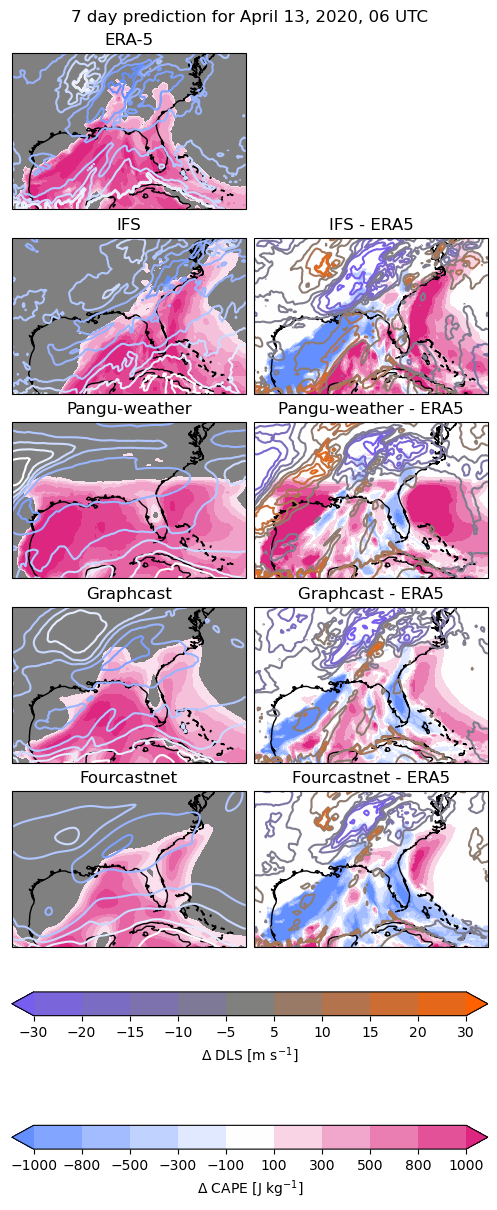

In [58]:
###READ FORECAST AT LEADTIME 7 DAYS
date='2020040600'
ii=28
pangu=xr.open_dataset(savepath+flag+'_conv_pangu-oper_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
graphcast=xr.open_dataset(savepath+flag+'_conv_graphcast-oper_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
fourcastnet=xr.open_dataset(savepath+flag+'_conv_sfno_'+date+'00.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
ifs=xr.open_dataset(savepath+flag+'_conv_ifs_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii+1).sel(latitude=latslice,longitude=lonslice)
era5=conv_era5.sel(time=pangu.time.values+pangu.prediction_timedelta.values)

###CAPE PLOT
cm= colors.LinearSegmentedColormap.from_list('mycmap', ['#FFFFFF', '#dc267f'])
cm.set_under(color="grey")
cm.set_bad(color="grey")
cmd = colors.LinearSegmentedColormap.from_list('mycmap', [ '#FFFFFF','#648fff'])  
cmd2 = colors.LinearSegmentedColormap.from_list('mycmap', ['#648fff', '#FFFFFF', '#dc267f'])  
cmd3 = colors.LinearSegmentedColormap.from_list('mycmap', ['#785ef0', '#808080', '#fe6100'])   
print('making plot')
n=0
projection = ccrs.PlateCarree()
#era_ref=era_ref.assign(mean_sea_level_pressure=lambda era_ref: xr_era5.mean_sea_level_pressure)
fig,axes = plt.subplots(5,2,figsize=(8,12), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')


era5.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[0,0],
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
era5.bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[0,0],
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both')
axes[0,0].coastlines()
axes[0,0].set_title('') # to supress xarray auto-title
axes[0,0].set_title('ERA-5')


ifs.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[1,0],
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
ifs.bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[1,0],
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both')
axes[1,0].coastlines()
axes[1,0].set_title('') # to supress xarray auto-title
axes[1,0].set_title('IFS')


pangu.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[2,0],
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
pangu.bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[2,0],
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both')
axes[2,0].coastlines()
axes[2,0].set_title('') # to supress xarray auto-title
axes[2,0].set_title('Pangu-weather')

graphcast.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[3,0],
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
graphcast.bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[3,0],
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both')
axes[3,0].coastlines()
axes[3,0].set_title('') # to supress xarray auto-title
axes[3,0].set_title('Graphcast')

fourcastnet.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[4,0],
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
fourcastnet.bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[4,0],
         cmap=cmd,vmin=5,vmax=51,levels=[5,10,15,20,30,40,50],extend='both')
axes[4,0].coastlines()
axes[4,0].set_title('') # to supress xarray auto-title
axes[4,0].set_title('Fourcastnet')


(ifs-era5).cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[1,1],
        cmap=cmd2,vmin=-1000,vmax=1000,levels=[-1000,-800,-500,-300,-100,100,300,500,800,1000],extend='both', add_colorbar=False)
(ifs-era5).bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[1,1],
         cmap=cmd3,vmin=-31,vmax=31,levels=[-30,-20,-15,-10,-5,5,10,15,20,30],extend='both')
axes[1,1].coastlines()
axes[1,1].set_title('') # to supress xarray auto-title
axes[1,1].set_title('IFS - ERA5')

(pangu-era5).cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[2,1],
        cmap=cmd2,vmin=-1000,vmax=1000,levels=[-1000,-800,-500,-300,-100,100,300,500,800,1000],extend='both', add_colorbar=False)
(pangu-era5).bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[2,1],
         cmap=cmd3,vmin=-31,vmax=31,levels=[-30,-20,-15,-10,-5,5,10,15,20,30],extend='both')
axes[2,1].coastlines()
axes[2,1].set_title('') # to supress xarray auto-title
axes[2,1].set_title('Pangu-weather - ERA5')

(graphcast-era5).cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[3,1],
        cmap=cmd2,vmin=-1000,vmax=1000,levels=[-1000,-800,-500,-300,-100,100,300,500,800,1000],extend='both', add_colorbar=False)
(graphcast-era5).bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[3,1],
         cmap=cmd3,vmin=-31,vmax=31,levels=[-30,-20,-15,-10,-5,5,10,15,20,30],extend='both')
axes[3,1].coastlines()
axes[3,1].set_title('') # to supress xarray auto-title
axes[3,1].set_title('Graphcast - ERA5')

line_plot=(fourcastnet-era5).bs_06.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[4,1],
         cmap=cmd3,vmin=-31,vmax=31,levels=[-30,-20,-15,-10,-5,5,10,15,20,30],extend='both', add_colorbar=False)
contour_plot=(fourcastnet-era5).cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=axes[4,1],
        cmap=cmd2,vmin=-1000,vmax=1000,levels=[-1000,-800,-500,-300,-100,100,300,500,800,1000],extend='both', add_colorbar=False)
(fourcastnet-era5).bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=axes[4,1],
         cmap=cmd3,vmin=-31,vmax=31,levels=[-30,-20,-15,-10,-5,5,10,15,20,30],extend='both')
axes[4,1].coastlines()
axes[4,1].set_title('') # to supress xarray auto-title
axes[4,1].set_title('Fourcastnet - ERA5')

axes[0,1].axis('off')

axs_flat = axes.flatten()


cbar = fig.colorbar(contour_plot, ax=axes, orientation='horizontal',ticks=[-1000,-800,-500,-300,-100,100,300,500,800,1000])
cbar.set_label('$\Delta$ CAPE [J kg$^{-1}$]')
#cbar.ax.tick_params(rotation=45)
cbar = fig.colorbar(line_plot, ax=axes, orientation='horizontal',ticks=[-30,-20,-15,-10,-5,5,10,15,20,30])
cbar.set_label('$\Delta$ DLS [m s$^{-1}$]')
fig.suptitle('7 day prediction for April 13, 2020, 06 UTC')
#plt.tight_layout()
fig.savefig(figpath+'plot_pred_long_cape_dls.png',  dpi=300, bbox_inches='tight')

In [59]:

print('CAPE',stats(era5.cape.values,ifs.cape.values,300,1000))
print('DLS',stats(era5.bs_06.values,ifs.bs_06.values,10,20))
print('WMS',stats((era5.bs_06 * (era5.cape*2)**0.5).values, (ifs.bs_06 * (ifs.cape*2)**0.5).values, 300,500))

CAPE (0.7008483987429132, 0.5826653195609499, 704.0001823733835, 3.1614238758897426, -0.11290219691652842, -0.020164084132560343, 0.13976324328186965)
DLS (0.9796605497405997, 0.8250838178456714, 9.414079924128066, -1.7903383, -0.01460140122861474, -0.10817171786393462, 0.01453533182444195)
WMS (0.6222047010873533, 0.598113335236541, 592.4442783111133, -57.76953101804004, 0.05094886128876102, -0.1913341652821103, 0.1363999578600537)
